Let's begin by loading the libraries:

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import os

from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from datasets import load_dataset

/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following code is necessary (on my machine at least) to be able to use multiple processes for data loading.

In [2]:
import torch.multiprocessing as mp
mp.set_start_method('fork', force=True)

## Introduction  

Generative Adversarial Networks (GANs) have revolutionized the field of generative modeling by introducing a framework where two neural networks—the Generator and the Discriminator—compete to produce realistic data. Among the variations of GANs, the Wasserstein GAN (WGAN) further improves stability and training dynamics, addressing some of the original GAN's challenges, such as mode collapse and sensitivity to hyperparameters. 

This notebook focuses on training both a standard GAN and a WGAN on the CelebFaces Attributes Dataset (CelebA), a popular dataset containing over 200,000 images of celebrity faces annotated with attributes. The CelebA dataset is widely used for tasks such as image generation, attribute manipulation, and other generative tasks due to its diversity and high quality.

### Objectives
1. **GAN Training:** Implement and train a standard GAN to generate realistic facial images by learning from the CelebA dataset.
2. **WGAN Training:** Explore the WGAN variant, which introduces the Wasserstein loss and the concept of gradient penalty.

### Key Concepts Covered
- **Image Preprocessing:** Preparing and augmenting the CelebA dataset for optimal training performance.
- **GAN Architecture:** A review of the Generator and Discriminator networks, along with their adversarial training dynamics.
- **WGAN Improvements:** An overview of Wasserstein loss and gradient penalty.

### Structure
1. **Data Preparation:** Load, preprocess, and visualize the CelebA dataset.
2. **GAN Implementation:** Define and train the Generator and Discriminator using the standard GAN framework.
3. **WGAN Implementation:** Modify the architecture and loss function to train using the WGAN framework.


## Data loading

We implement the data-loading process with *data augmentation* applied to the training data.

We also note that only minimal *data augmentation* is applied, specifically reflections. This is because the task is not a classification problem; instead, we aim to generate realistic face images. Thus, augmentations like color or saturation distortions could lead to the generation of such distortions later. Rotation is also excluded, as it resulted in a loss of quality due to the image resolution.

In [3]:
IMAGE_SIZE = 64  # use images of 64x64 pixels

TRAIN_BATCH_SIZE = 512
VAL_BATCH_SIZE = 512

In [4]:
dataset = load_dataset("tpremoli/CelebA-attrs")

/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
class CollateFn:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, batch):
        images = torch.stack([self.transform(item.pop("image")) for item in batch])
        return images, batch
    
class CelebADataModule(pl.LightningDataModule):
    def __init__(self, train_batch_size, val_batch_size):
        super().__init__()
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size

    def setup(self, stage=None):
        dataset = load_dataset("tpremoli/CelebA-attrs")
        self.train_dataset = dataset["train"]
        self.val_dataset = dataset["validation"]

        train_transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),  # A bit of augmentation
            transforms.ToTensor(),
        ])
        self.train_collate_fn = CollateFn(train_transform)

        val_transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
        ])
        self.val_collate_fn = CollateFn(val_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            shuffle=True,
            collate_fn=self.train_collate_fn,
            num_workers=16,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            shuffle=False,
            collate_fn=self.val_collate_fn,
            num_workers=16,
        )

Let's see some example faces:

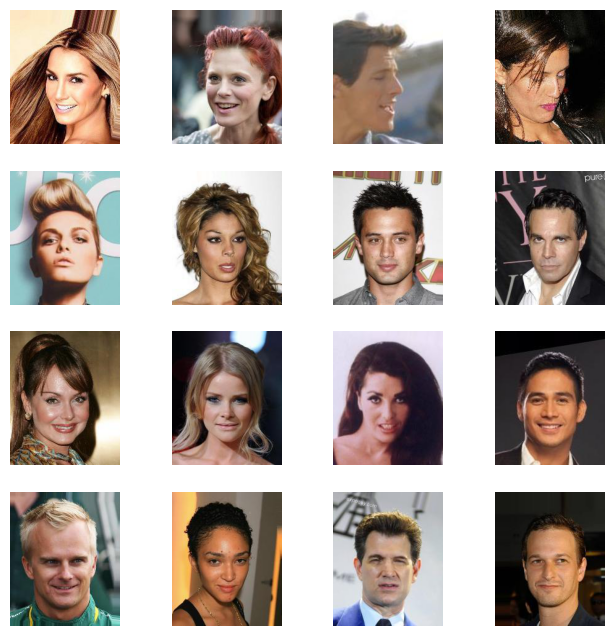

In [6]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(dataset["train"][i]["image"])
    plt.axis("off")


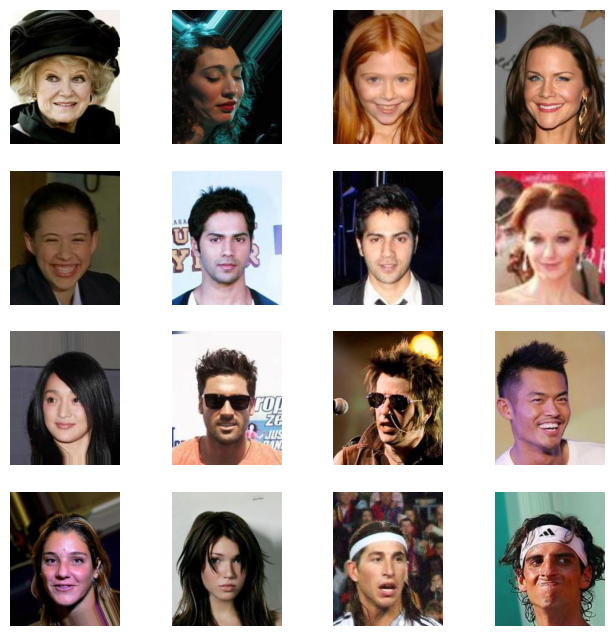

In [7]:
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(dataset["validation"][i]["image"])
    plt.axis("off")

## Vanilla GAN

### The generator and the discriminator

We begin by defining our two networks: the **generator** and the
**discriminator**. They are similar to the decoder and the encoder in VAEs,
respectively, in the sense that the generator takes a latent vector
representation and upsamples it to become a full image, and the discriminator
takes a full image and progressively summarizes it until a single vector,
although in this case it is used to classify the image as false or real. As
you can see, we use the same blocks!

In [8]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 1024 * 2 * 2)
        self.nn = nn.Sequential(
            *self.__get_decoder_block(1024, 512),  # 1024x2x2 -> 512x4x4
            *self.__get_decoder_block(512, 256),  # 512x4x4 -> 256x8x8
            *self.__get_decoder_block(256, 128),  # 256x8x8 -> 128x16x16
            *self.__get_decoder_block(128, 64),  # 128x16x16 -> 64x32x32
            *self.__get_decoder_block(64, 32),  # 64x32x32 -> 32x64x64
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),  # 16x64x64 -> 3x64x64
            nn.Sigmoid(),
        )

    def forward(self, z):
        x = self.fc1(z).view(-1, 1024, 2, 2)
        return self.nn(x)
    
    def __get_decoder_block(self, input_channels, output_channels):
        return [
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        ]

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.nn = nn.Sequential(
            *self.__get_encoder_block(3, 64),  # 3x64x64 -> 64x32x32
            *self.__get_encoder_block(64, 128),  # 64x32x32 -> 128x16x16
            *self.__get_encoder_block(128, 256),  # 128x16x16 -> 256x8x8
            *self.__get_encoder_block(256, 512),  # 256x8x8 -> 512x4x4
            *self.__get_encoder_block(512, 1024),  # 512x4x4 -> 1024x2x2
            nn.Flatten(),
            nn.Linear(1024 * 2 * 2, 1),
        )

    def forward(self, x):
        return self.nn(x)

    def __get_encoder_block(self, input_channels, output_channels):
        return [
            nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2),
        ]

### Training

We now get to our training module in Pytorch Lightning!

#### Disabling automatic optimization
Unfortunately, we must define each optimization step ourselves, as this is not
your simple neural network training. We now have two different optimizers, and
we need to train two networks. However, using Pytorch Lightning is still useful
to handle devices, precision, etc.

The important parts to implement this are setting the `automatic_optimization`
of the LightningModule to `false` in the constructor, and then applying the
`optimizer.zero_grad()`, the `loss.backward()` (although Pytorch Lightning has a
method for this) and the `optimizer.step()` in the `training_step` method.

#### The loss function

You will also notice that the loss function is not exactly what we explained in class! We
are using the `binary_cross_entropy` loss, and in particular its version with logits.
You will notice that our discriminator doesn't return a probability, as we did not apply
the `sigmoid` function.

Let's recap first the GAN loss function we saw in class. The discriminator tries to:
1. **Classify real data as real** (output close to 1).
2. **Classify fake data as fake** (output close to 0).

The loss for the discriminator is:
$$
D_{\text{loss}} = -\mathbb{E}_{x \sim \text{real data}} [\log D(x)] - \mathbb{E}_{z \sim \text{noise}} [\log (1 - D(G(z)))]
$$
- $D(x)$: Discriminator output for real data.
- $D(G(z))$: Discriminator output for fake data generated by the generator.

The generator tries to **maximize** the discriminator’s error on fake data, effectively trying to make $D(G(z))$ approach 1:
$$
G_{\text{loss}} = \mathbb{E}_{z \sim \text{noise}} [\log (1 - D(G(z)))]
$$

##### How is this connected to Binary Cross-Entropy (BCE)?
The GAN losses are closely related to **Binary Cross-Entropy (BCE)**, a common
loss function for binary classification problems. BCE is defined as:
$$
\text{BCE}(y, \hat{y}) = -[y \cdot \log(\hat{y}) + (1-y) \cdot \log(1-\hat{y})]
$$
- $y$: True label (1 for real, 0 for fake).
- $\hat{y}$: Predicted probability.

In the GAN context:
- For **real data** ($y = 1$), the loss is:
  $$
  -\log(D(x))
  $$
- For **fake data** ($y = 0$), the loss is:
  $$
  -\log(1 - D(G(z)))
  $$

The discriminator's total loss is just the average BCE loss over real and fake data:
$$
D_{\text{loss}} = \text{BCE}(\text{real label}, D(x)) + \text{BCE}(\text{fake label}, D(G(z)))
$$

##### Why Use `binary_cross_entropy_with_logits`?
You will notice that the discriminator doesn't output a probability, but an
arbitrary real number.  These correspond to the values prior to applying the
`sigmoid` function, and are called **logits**.  PyTorch provides the
`binary_cross_entropy_with_logits` function, which simplifies this process by
combining two operations:
1. **Applies the log-sigmoid function** to the raw outputs (logits) from the discriminator.
   - Logits are the raw scores before applying the sigmoid function.
   - Sigmoid transforms logits into probabilities.
2. **Computes BCE loss** directly on the logits.

Operating on logits instead of probabilities improves numerical stability. When
probabilities are close to 0 or 1, $\log(1-\hat{y})$ or $\log(\hat{y})$ can
cause numerical issues. Using logits avoids these problems.

##### Implementation

In PyTorch, you can define the discriminator and generator losses using `binary_cross_entropy_with_logits` as follows.

The **discriminator’s loss** combines the real and fake losses:
```python
D_loss = F.binary_cross_entropy_with_logits(D_real_logits, torch.ones_like(D_real_logits)) + \
         F.binary_cross_entropy_with_logits(D_fake_logits, torch.zeros_like(D_fake_logits))
```
- `D_real_logits`: Logits (raw outputs) for real data.
- `D_fake_logits`: Logits for fake data.
- `torch.ones_like` and `torch.zeros_like` create labels (1 for real, 0 for fake).

The naive **generator’s loss** is the opposite of the discriminator's loss (that is, `-D_loss`):
```python
G_loss = -F.binary_cross_entropy_with_logits(D_fake_logits, torch.zeros_like(D_fake_logits))
```
Notice how the first term of `D_loss` above does not appear! This is because the term does not depend on the generator, and thus when you take derivatives it dissapears.


You may remember from class that we used a different non-saturating loss:
$$
G_{\text{loss}} = -\mathbb{E}_{z \sim \text{noise}} [\log D(G(z))]
$$
This corresponds to:
```python
G_loss = F.binary_cross_entropy_with_logits(D_fake_logits, torch.ones_like(D_fake_logits))
```

---
**TL;DR**
1. We need to implement the optimization process ourselves instead of letting Pytorch
   lightning handle it, as we train two networks alternatively.
2. **Classical GAN losses** are based on log-likelihoods for binary classification.
3. These losses naturally correspond to **Binary Cross-Entropy (BCE)** loss.
4. PyTorch’s `binary_cross_entropy_with_logits`:
   - Simplifies the process by combining sigmoid and BCE computation.
   - Avoids numerical instability by working with logits.

In [9]:
class GANModule(pl.LightningModule):
    def __init__(self, opt_g_params, opt_d_params, z_dim=128):
        super(GANModule, self).__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.opt_g_params = opt_g_params
        self.opt_d_params = opt_d_params

        # NOTE: Disable automatic optimization to manually control the training loop
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        """
        Training step for the GAN module. We need to perform the optimization manually,
        so we disable the automatic optimization and implement the training loop ourselves.
        Each training loop consists of two steps:
            1. Train the discriminator
            2. Train the generator
        """
        # Get optimizers
        opt_D, opt_G = self.optimizers()

        # ================================================== #
        # ================== Prepare data ================== #
        # ================================================== #
        real_images, _ = batch  # [B, 3, 64, 64]
        z = torch.randn(real_images.size(0), self.z_dim).to(self.device)  # [B, z_dim]
        fake_images = self.generator(z)  # [B, 3, 64, 64]

        # ========================================================= #
        # ================== Train Discriminator ================== #
        # ========================================================= #
        opt_D.zero_grad()

        D_real = self.discriminator(real_images)
        D_fake = self.discriminator(fake_images.detach())  # NOTE: detach the fake_images tensor to avoid computing gradients for the generator
        loss_D = (
            F.binary_cross_entropy_with_logits(D_real, torch.ones_like(D_real)) +
            F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))
        )

        self.manual_backward(loss_D)
        opt_D.step()

        # ===================================================== #
        # ================== Train Generator ================== #
        # ===================================================== #
        opt_G.zero_grad()

        D_fake = self.discriminator(fake_images)
        # loss_G = -F.binary_cross_entropy_with_logits(D_fake, torch.zeros_like(D_fake))  # NOTE: original GAN loss
        loss_G = F.binary_cross_entropy_with_logits(D_fake, torch.ones_like(D_fake))  # NOTE: non-saturating GAN loss

        self.manual_backward(loss_G)
        opt_G.step()

        # ================================================= #
        # ================== Log Results ================== #
        # ================================================= #
        self.log("loss_D", loss_D, on_step=True, on_epoch=False, prog_bar=True)
        self.log("loss_G", loss_G, on_step=True, on_epoch=False, prog_bar=True)

        return {"loss_D": loss_D, "loss_G": loss_G}

    def configure_optimizers(self):
        opt_D = optim.AdamW(self.discriminator.parameters(), **self.opt_d_params)
        opt_G = optim.AdamW(self.generator.parameters(), **self.opt_g_params)
        return [opt_D, opt_G], []
    
    def on_train_epoch_end(self):
        """
        Generate example images at the end of each epoch
        """
        os.makedirs("output/vanilla", exist_ok=True)
        file_path = f"output/vanilla/generator_epoch_{self.current_epoch}.png"
        z = torch.randn(64, self.z_dim).to(self.device)
        generated_images = self.generator(z)
        save_image(generated_images, file_path, nrow=8, normalize=True)
        return super().on_train_epoch_end()

In [10]:
data_module = CelebADataModule(TRAIN_BATCH_SIZE, VAL_BATCH_SIZE)
data_module.setup()

In [11]:
ZDIM = 128
OPT_G_PARAMS = {
    "lr": 1.5e-4,
    "betas": (0.5, 0.999),
}
OPT_D_PARAMS = {
    "lr": 1e-4,
    "betas": (0.5, 0.999),
}

In [12]:
model = GANModule(OPT_G_PARAMS, OPT_D_PARAMS, ZDIM)
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=[0])
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/pablo/.micromamba/envs/mdl_gen/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly u

Epoch 19: 100%|██████████| 318/318 [00:58<00:00,  5.46it/s, v_num=11, loss_D=0.843, loss_G=2.970]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 318/318 [00:58<00:00,  5.40it/s, v_num=11, loss_D=0.843, loss_G=2.970]


### Generating images

Let's plot the images generated after the last epoch:

![Vanilla GAN images](output/vanilla/generator_epoch_19.png)

As we can see, even if there are some weird images, some of the generated faces
are of good quality! This contrasts with the VAE, where all the images were
fairly blurry.

### Uninformative loss

As explained in the lecture and shown next, the loss values oscillate a lot and
do not go down! This is because the problem at each optimization step is different:
both the discriminator and generator are (or should be) better, making it a harder
problem for the other network. Thus, if the loss stays the same, the networks maintain
their performance in an increasingly hard problem!

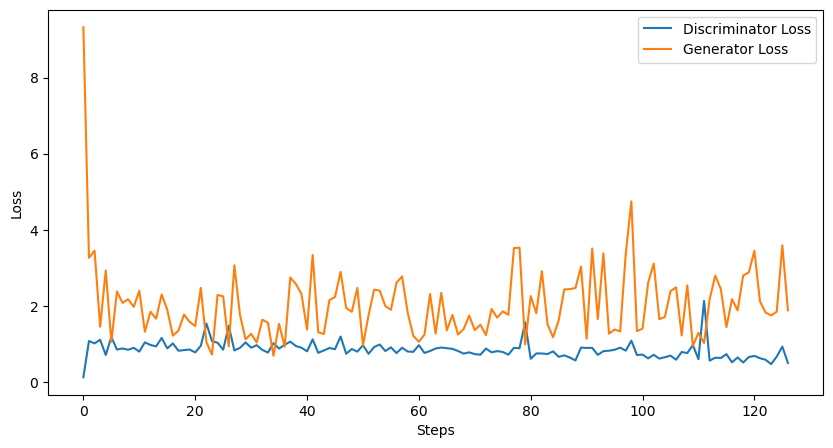

In [13]:
df = pd.read_csv("lightning_logs/version_1/metrics.csv")

plt.figure(figsize=(10, 5))
plt.plot(df["loss_D"], label="Discriminator Loss")
plt.plot(df["loss_G"], label="Generator Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Wasserstein GAN with Gradient Penalty

We now get to WGANs, which modify the loss function as explained in class.
The only part that should not be familiar by now is the `__compute_gradient_penalty`
function, so we will explain it step by step!

The `__compute_gradient_penalty` function calculates the gradient penalty, that
is, the regularization term used in Wasserstein GAN with Gradient Penalty
(WGAN-GP) to enforce the Lipschitz constraint on the discriminator. It receives
two inputs:
- **`real_images`**: A batch of real images (tensors) sampled from the dataset.
- **`fake_images`**: A batch of fake images generated by the generator.

**Interpolating the real and fake images**
```python
alpha = torch.rand(B, 1, 1, 1, device=device).expand_as(real_images)
interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
```
- A random weight `alpha` is generated for each image in the batch, with values sampled from a uniform distribution between 0 and 1. Its shape is `(B, 1, 1, 1)` and is broadcast to match the shape of `real_images` using `.expand_as(real_images)`.
- The interpolation is computed as:
    \[
    \text{interpolates} = \alpha \cdot \text{real\_images} + (1 - \alpha) \cdot \text{fake\_images}
    \]
    This creates new images that are a mix of real and fake images.
- The `.requires_grad_(True)` marks the `interpolates` tensor for gradient computation.

I have not really found a reason for using interpolations instead of the images, but it probably
yields better results empirically as it is often used.


**Passing Interpolated Images Through the Discriminator**
```python
D_interpolates = self.discriminator(interpolates)
```

**Computing Gradients w.r.t. Interpolated Images**:
```python
gradients = torch.autograd.grad(
    outputs=D_interpolates,
    inputs=interpolates,
    grad_outputs=torch.ones_like(D_interpolates),
    create_graph=True,
    retain_graph=True,
    only_inputs=True
)[0]
```
- The gradients of `D_interpolates` (scalar outputs of the discriminator) with respect to the interpolated images are computed using `torch.autograd.grad`.
  - `outputs=D_interpolates`: The outputs for which gradients are computed.
  - `inputs=interpolates`: The inputs w.r.t. which gradients are computed.
  - `grad_outputs=torch.ones_like(D_interpolates)`: These values merely multiply all the computed gradients, we won't worry about it here.
  - `create_graph=True`: Enables the computation of higher-order derivatives, as the gradients will be used in a differentiable computation (to enforce the penalty).
  - `retain_graph=True`: Keeps the computation graph in memory for further use.
  - `only_inputs=True`: Computes gradients only for the `interpolates` tensor.
- The result is stored in `gradients`.

**Flattening and Computing the Gradient Norm**:
```python
gradients = gradients.view(B, -1)
gradient_norm = gradients.norm(2, dim=1)
```
- `gradients.view(B, -1)` flattens each gradient tensor (representing the gradient of a single interpolated image) into a 2D tensor of shape `(B, *)`.
- The L2 norm of each flattened gradient tensor is computed along the last dimension (`dim=1`):
  $$
  \text{gradient\_norm}[i] = \sqrt{\sum_{j} (\text{gradients}[i, j])^2}
  $$

**Computing the Gradient Penalty**:
```python
gradient_penalty = ((gradient_norm - 1) ** 2).mean()
```
- The gradient penalty enforces that the norm of the gradient should be close to 1 (as required by the Lipschitz constraint):
  $$
  \text{gradient\_penalty} = \text{mean}((\|\nabla\|_2 - 1)^2)
  $$
  The penalty is minimized when the gradient norm is close to 1.

The function returns the scalar `gradient_penalty`, which is used as a
regularization term in the loss function to train the discriminator in WGAN-GP.

In [21]:
class WGANModule(pl.LightningModule):
    def __init__(self, opt_g_params, opt_d_params, lambda_gp=10., z_dim=128):
        super(WGANModule, self).__init__()
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()
        self.z_dim = z_dim
        self.opt_g_params = opt_g_params
        self.opt_d_params = opt_d_params
        self.lambda_gp = lambda_gp

        # NOTE: Disable automatic optimization to manually control the training loop
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx):
        """
        Training step for the GAN module. We need to perform the optimization manually,
        so we disable the automatic optimization and implement the training loop ourselves.
        Each training loop consists of two steps:
            1. Train the discriminator
            2. Train the generator
        """
        # Get optimizers
        opt_D, opt_G = self.optimizers()

        # ================================================== #
        # ================== Prepare data ================== #
        # ================================================== #
        real_images, _ = batch  # [B, 3, 64, 64]
        z = torch.randn(real_images.size(0), self.z_dim).to(self.device)  # [B, z_dim]
        fake_images = self.generator(z)  # [B, 3, 64, 64]

        # ========================================================= #
        # ================== Train Discriminator ================== #
        # ========================================================= #
        opt_D.zero_grad()

        D_real = self.discriminator(real_images).mean()
        # NOTE: detach the fake_images tensor to avoid computing gradients for the generator
        D_fake = self.discriminator(fake_images.detach()).mean()
        gradient_penalty = self.__compute_gradient_penalty(real_images, fake_images.detach())
        loss_D = -(D_real - D_fake) + self.lambda_gp * gradient_penalty

        self.manual_backward(loss_D)
        opt_D.step()

        # ===================================================== #
        # ================== Train Generator ================== #
        # ===================================================== #
        opt_G.zero_grad()

        D_fake = self.discriminator(fake_images).mean()
        loss_G = -D_fake

        self.manual_backward(loss_G)
        opt_G.step()

        # ================================================= #
        # ================== Log Results ================== #
        # ================================================= #
        self.log("loss_D", loss_D, on_step=True, on_epoch=False, prog_bar=True)
        self.log("loss_G", loss_G, on_step=True, on_epoch=False, prog_bar=True)

        return {"loss_D": loss_D, "loss_G": loss_G}

    def __compute_gradient_penalty(self, real_images, fake_images):
        """
        Computes the gradient penalty for WGAN-GP.
        """
        B, *_ = real_images.size()
        device = real_images.device
        # Random interpolation between real and fake images
        alpha = torch.rand(B, 1, 1, 1, device=device).expand_as(real_images)
        interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)

        # Discriminator's output for interpolated images
        D_interpolates = self.discriminator(interpolates)

        # Compute gradients with respect to the interpolated images
        gradients = torch.autograd.grad(
            outputs=D_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(D_interpolates),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(B, -1)  # Flatten gradients
        gradient_norm = gradients.norm(2, dim=1)  # L2 norm
        gradient_penalty = ((gradient_norm - 1) ** 2).mean()  # Gradient penalty

        return gradient_penalty


    def configure_optimizers(self):
        opt_D = optim.AdamW(self.discriminator.parameters(), **self.opt_d_params)
        opt_G = optim.AdamW(self.generator.parameters(), **self.opt_g_params)
        return [opt_D, opt_G], []
    
    def on_train_epoch_end(self):
        """
        Generate example images at the end of each epoch
        """
        os.makedirs("output/wgan", exist_ok=True)
        file_path = f"output/wgan/generator_epoch_{self.current_epoch}.png"
        z = torch.randn(64, self.z_dim).to(self.device)
        generated_images = self.generator(z)
        save_image(generated_images, file_path, nrow=8, normalize=True)
        return super().on_train_epoch_end()

In [22]:
data_module = CelebADataModule(TRAIN_BATCH_SIZE, VAL_BATCH_SIZE)
data_module.setup()

In [23]:
ZDIM = 128
LAMBDA_GP = 10.
OPT_G_PARAMS = {
    "lr": 1.5e-4,
    "betas": (0.5, 0.999),
}
OPT_D_PARAMS = {
    "lr": 1e-4,
    "betas": (0.5, 0.999),
}

In [25]:
wgan_model = WGANModule(OPT_G_PARAMS, OPT_D_PARAMS, LAMBDA_GP, ZDIM)
trainer = pl.Trainer(max_epochs=20, accelerator="gpu", devices=[0])
trainer.fit(wgan_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 6.8 M 
1 | discriminator | Discriminator | 6.3 M 
------------------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.385    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 318/318 [01:22<00:00,  3.88it/s, v_num=9, loss_D=-0.891, loss_G=7.530]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 318/318 [01:22<00:00,  3.85it/s, v_num=9, loss_D=-0.891, loss_G=7.530]
